---
# Import Libraries
---

In [31]:
import numpy as np 
import pandas 
import csv
import warnings
import nltk
import os
import string
import time
import pickle
import seaborn as sns
from pathlib import Path
import transformers
import torch
import random
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer,RobertaTokenizerFast, RobertaForSequenceClassification
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
import matplotlib.pyplot as plt
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,multilabel_confusion_matrix,plot_confusion_matrix
import warnings
warnings.filterwarnings("ignore")

---
# Upload data
---

In [32]:
src='/home/shared_data/textmining_genderrecognition_topicextraction/dataset_text_mining_Reuters_RCV2/'
# src='C:/Users/matti/Desktop/progetto/Dataset/'
labels_59=False

with open (src+'outputfile_text_processed.csv', 'r') as temp:
    processed_text_final = pandas.read_csv(temp)

if labels_59==True:
    y_label_code = np.loadtxt(src+'numeric_label_topic_59.txt', dtype=int)
else:
    y_label_code = np.loadtxt(src+'numeric_label_topic.txt', dtype=int)
y_label_code=y_label_code.tolist()
print(len(y_label_code))

if labels_59==True:
    with open("myDictionary_labels_59.npy", "rb") as tf:
        new_dict = np.load(tf, allow_pickle='TRUE')
else:
    with open("myDictionary_labels.npy", "rb") as tf:
        new_dict = np.load(tf, allow_pickle='TRUE')
new_dict.item()

800803


{'CORPORATE/INDUSTRIAL': 'CORPORATE/INDUSTRIAL',
 'ECONOMICS': 'ECONOMICS',
 'GOVERNMENT/SOCIAL': 'GOVERNMENT/SOCIAL',
 'MARKETS': 'MARKETS'}

In [33]:
y_label_code_column=[]
for row in y_label_code:
    lab=(''.join(map(str, row)))
    y_label_code_column.append(lab)
len(y_label_code_column)

800803

In [34]:
Data_Set=pandas.DataFrame({'text':list(processed_text_final['text']),'target':y_label_code_column})
Data_Set.head(1)

,text,target
0,uk share market unlikely make much headway nex...,0001


---
# REDUCTION DATASET
---

In [35]:
from datetime import datetime
def time_calculate(bool_t=True,start_time=0):
    if bool_t==True:
        print('START: ',datetime.today().strftime('%Y-%m-%d %H:%M'))
        return time.time()
    else:
        end_time=time.time()
        print('END: ',datetime.today().strftime('%Y-%m-%d %H:%M'))
        giorno_in_sec=86400
        giorni=(int(end_time)-int(start_time))//giorno_in_sec
        t = time.strftime("%Hh:%Mm:%Ss",time.gmtime(int(end_time)-int(start_time)))
        print("tempo impiegato "+str(giorni)+'d:'+t)
        return t
def plot_token_occ(x,start,end, genere,title):
    token_lens = []
    for txt in x:
        txt_l=(str(txt)).split(' ')
        token_lens.append(len(txt_l))
    media=np.mean(token_lens)
    sns.histplot(token_lens)
    plt.xlim([start,end])
    plt.xlabel('Text count')
    plt.title(title+genere+" ="+ str(round(media,2)))
    plt.show()

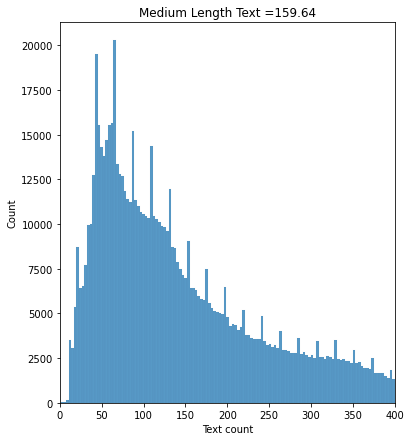

In [36]:
plot_token_occ(Data_Set['text'].tolist(),0,400,'','Medium Length Text')

In [37]:
delete=0
start_row=35
end_row=150 #len(Data_Set)
print('prima--->',len(Data_Set),'!')
start_time=time_calculate()
delete=len(Data_Set[(Data_Set['text'].map(lambda x: len(x.split(' ')))> end_row) ])+len(Data_Set[(Data_Set['text'].map(lambda x: len(x.split(' ')))< start_row)])
Data_Set = Data_Set[(Data_Set['text'].map(lambda x: len(x.split(' ')))<= end_row) ]
Data_Set = Data_Set[(Data_Set['text'].map(lambda x: len(x.split(' ')))>= start_row) ]
Data_Set = Data_Set.reset_index(drop=True)
end_time=time_calculate(bool_t=False,start_time=start_time)
print('ora--->',len(Data_Set),', eliminati',delete,'record su',800803 ,'!')

prima---> 800803 !
START:  2022-03-27 14:24
END:  2022-03-27 14:24
tempo impiegato 0d:00h:00m:32s
ora---> 439176 , eliminati 361627 record su 800803 !


In [38]:
def crea_label_vector(Data_Set):
    y_label_code_reduced=[]
    for index, row in Data_Set.iterrows():
        row_t=(list(row['target']))
        row_t=[int(x) for x in row_t]
        y_label_code_reduced.append(row_t)
    print('size ridotta',len(y_label_code_reduced))
    return y_label_code_reduced
class_names_list=new_dict.item()
target_names=[x for x in class_names_list.keys()]
y_label_code_reduced=crea_label_vector(Data_Set)

size ridotta 439176


---
## Check that there are enough examples and balance the labels
---

In [39]:
def stat_ds(y_label_code_reduced):
    x=np.zeros(len(y_label_code_reduced[0]),dtype=int)
    for v in y_label_code_reduced:
        x=x+v
    c=0
    for v in x:
        if v==0:
            c+=1
    print(x)
    print('esempi = 0 :',c)
    #percentuali sull'intero dataset
    xx=x.copy()
    z=[]
    for l in xx:
        z.append(str(round((l/len(Data_Set))*100,1))+'%')
    print(z)
    return x#,[float(x[:4]) for x in z]
    
stat_ds_list=stat_ds(y_label_code_reduced)

[244323  55827  94588 109071]
esempi = 0 : 0
['55.6%', '12.7%', '21.5%', '24.8%']


In [40]:
def _red_list_bal(y_label_code_reduced):
    c=stat_ds(y_label_code_reduced)
    min_l=min(c)
    red=[0,0,0,0]
    ind=0
    for i in c:
        if i!=min_l:
            val=c[ind]#int((i/100)*len(Data_Set))
            red[ind]=val-min_l#int((min_l/100)*len(Data_Set))
        else:
            red[ind]=1
        ind+=1
    return red

In [41]:
def indx_permutati(Data_Set):
    random.seed(42)
    ind_ds=random.sample(range(len(Data_Set)), len(Data_Set))
    return ind_ds

In [42]:
def bilancia(Data_Set):
    size_prima=len(Data_Set)
    conta1=0
    conta2=0
    conta3=0
    conta4=0
    index=0
    red=_red_list_bal(y_label_code_reduced)
    indx_perm=indx_permutati(Data_Set)
    index_list=[]
    row_list=Data_Set['target'].tolist()
    for row_ind in indx_perm:
        row=row_list[row_ind]
        row_t=[int(x) for x in row]
        if sum(row_t)==1:
            if row_t[0]==1 and conta1<red[0]:
                index_list.append(row_ind)
                conta1+=1
            if row_t[1]==1 and conta1<red[1]:
                index_list.append(row_ind)
                conta2+=1
            if row_t[2]==1 and conta3<red[2]:
                index_list.append(row_ind)
                conta3+=1
            if row_t[3]==1 and conta4<red[3]:
                index_list.append(row_ind)
                conta4+=1
        
        index+=1
        if index%100000==0 and index!=0:
            print('analizzati',index)
    Data_Set.drop(index_list, inplace=True)
    Data_Set.reset_index(drop=True)
    print('eliminati come prima label',conta1,'\neliminati come seconda label',conta2,'\neliminati come terza label',conta3,'\neliminati come quarta label',conta4,'\nsize ridotta da',size_prima,'a',len(Data_Set))

start_time=time_calculate()
if labels_59!=True:
    bilancia(Data_Set)
else:
    random.seed(42)
    ind_ds=random.sample(range(len(Data_Set)), int(len(Data_Set)/1.5))
    Data_Set.drop(ind_ds, inplace=True)
    Data_Set=Data_Set.reset_index(drop=True)
end_time=time_calculate(bool_t=False,start_time=start_time)

START:  2022-03-27 14:26
[244323  55827  94588 109071]
esempi = 0 : 0
['55.6%', '12.7%', '21.5%', '24.8%']
analizzati 100000
analizzati 200000
analizzati 300000
analizzati 400000
eliminati come prima label 188496 
eliminati come seconda label 1 
eliminati come terza label 38761 
eliminati come quarta label 53244 
size ridotta da 439176 a 158674
END:  2022-03-27 14:26
tempo impiegato 0d:00h:00m:04s


In [43]:
y_label_code_reduced=crea_label_vector(Data_Set)
stat_ds(y_label_code_reduced)

size ridotta 158674
[55827 55826 55827 55827]
esempi = 0 : 0
['35.2%', '35.2%', '35.2%', '35.2%']


array([55827, 55826, 55827, 55827])

---
# Division of data in Train Validation and Test
---

In [44]:
# prima splitta in train test
X = list(Data_Set['text'])
y = y_label_code_reduced
if labels_59==True:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.33, random_state=42)
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42,stratify=y)
    X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.33, random_state=42,stratify=y_test)
print('Size iniziale dei record:',len(list(Data_Set['text'])),'\nSize train ds:',len(X_train),', Size train label:', len(y_train),'\nSize validation ds:',len(X_validation),', Size validation label:',len(y_validation),'\nSize test ds:',len(X_test),'Size test label:', len(y_test))

Size iniziale dei record: 158674 
Size train ds: 111071 , Size train label: 111071 
Size validation ds: 31894 , Size validation label: 31894 
Size test ds: 15709 Size test label: 15709


---
# Models
---

In [45]:
# PCA
path_pca="/home/mattia_gatto/text-mining-use-cases/src/use_cases/use_case_topic_classification/Models/PCA/"
# path_pca='C:/Users/matti/Desktop/progetto/text-mining-use-cases-mattia_gatto/src/use_cases/use_case_topic_classification/Models/PCA/'

start_time=time_calculate()
if labels_59!=True:
    f1=path_pca+'X_tfidf_pca'
else:
    f1=path_pca+'X_tfidf_pca_59'
X_tfidf_pca = pickle.load(open(f1, 'rb'))
end_time=time_calculate(bool_t=False,start_time=start_time)

start_time=time_calculate()
if labels_59!=True:
    f2=path_pca+'X_tfidf_validation_pca'
else:
    f2=path_pca+'X_tfidf_validation_pca_59'
X_tfidf_validation_pca = pickle.load(open(f2, 'rb'))
end_time=time_calculate(bool_t=False,start_time=start_time)

start_time=time_calculate()
if labels_59!=True:
    f3=path_pca+'X_tfidf_test_pca'
else:
    f3=path_pca+'X_tfidf_test_pca_59'
X_tfidf_test_pca = pickle.load(open(f3, 'rb'))
end_time=time_calculate(bool_t=False,start_time=start_time)

START:  2022-03-27 14:26
END:  2022-03-27 14:27
tempo impiegato 0d:00h:00m:21s
START:  2022-03-27 14:27
END:  2022-03-27 14:27
tempo impiegato 0d:00h:00m:01s
START:  2022-03-27 14:27
END:  2022-03-27 14:27
tempo impiegato 0d:00h:00m:00s


In [46]:
import pandas as pd
def plot_classification_report(classification_report, title='', cmap='RdBu',num_class=4,size=(6,7)):
    title_='Classification report '+title
    plt.title(title_, fontsize=20)
    plt.rcParams["figure.figsize"] = size
    lines = classification_report.split('\n')
    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) )]:
        t = line.strip().split()
        if len(t) < 2: continue
        if t[1]=='avg':
            classes.append(t[0]+t[1])
            start=2
        else:
            classes.append(t[0])
            start=1
        if t[0]== 'accuracy':
            v=[float(),float(),float(t[1])]
        else:
            v = [float(x) for x in t[start: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    class_names[len(class_names)-1]=class_names[len(class_names)-1]+' avg'
    class_names[len(class_names)-2]=class_names[len(class_names)-2]+' avg'
    class_names[len(class_names)-3]=class_names[len(class_names)-3]+' avg'
    class_names[len(class_names)-4]=class_names[len(class_names)-4]+' avg'
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    plotMat.insert(num_class, plotMat[3])
    yticklabels.insert(num_class, '')
    data=pd.DataFrame(np.array(plotMat))
    data[0][num_class]=None
    data[1][num_class]=None
    data[2][num_class]=None
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    sns.heatmap(data, annot=True,xticklabels=xticklabels,yticklabels=yticklabels, annot_kws={"size": 20})
    plt.show()

In [47]:
def plot_confusion_matrix(cm):
    fig = plt.figure(figsize=(10,10))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(class_names_list, fontsize =8) 
    ax.yaxis.set_ticklabels(class_names_list, fontsize =8)
    plt.show()

def train_classifier(f,model,class_names_list,n_job=-1):
    start_time=time_calculate()
        
    if os.path.isfile(f):
        clf = pickle.load(open(f, 'rb'))
        multi_output_classifier = clf
        print("MODELLO GIA' ADDESTRATO")
    else:
        print('TRAINING MODEL')
        clf = model
        multi_output_classifier = MultiOutputClassifier(clf, n_jobs=n_job)
        multi_output_classifier.fit(X_Train, y_train);
        print("MODELLO ADDESTRATO")
        pickle.dump(multi_output_classifier, open(f, 'wb'))

    end_time=time_calculate(bool_t=False,start_time=start_time)

    y_pred = multi_output_classifier.predict(X_Validation);  # etichette predette
#     ris_metrics_acc=metrics.accuracy_score(y_validation, y_pred)
    ris_metrics_auc=0.0
    if labels_59!=True:
        ris_metrics_auc=roc_auc_score(y_validation, y_pred)
    
        cm = metrics.confusion_matrix(np.argmax(y_validation, axis=1),np.argmax(y_pred, axis=1))
        plot_confusion_matrix(cm)
        
        cr=classification_report(y_validation, y_pred, target_names=class_names_list)
        plot_classification_report(cr, title='',num_class=4,size=(6,7))
        print("ROC AUC SCORE:", ris_metrics_auc)
    else:
        cr=classification_report(y_validation, y_pred, target_names=class_names_list)
        plot_classification_report(cr, title='',num_class=59,size=(20,30))
    
    return multi_output_classifier,y_pred,ris_metrics_auc

def val_5fold(model,x_test,y_test,f,n_job=-1) :
    metrics_="f1_micro"
    if os.path.isfile(f+'_'+metrics_):
        score_5_fold = pickle.load(open(f+'_'+metrics_, 'rb'))
        print("MODELLO PRECEDENTEMENTE VALIDATO CARICATO")
        return score_5_fold
    else:
#         metrics_=["f1_micro","f1_macro","f1_weighted","f1_samples","neg_log_loss","precision","recall","roc_auc"]
        score_5_fold = cross_val_score(model,x_test ,y_test,scoring=metrics_,n_jobs=n_job ,cv=5)
        print("MODELLO VALIDATO")
        pickle.dump(score_5_fold, open(f+'_'+metrics_, 'wb'))
        return score_5_fold

def prediction(multi_output_classifier,X_Test,y_test):
    y_pred=multi_output_classifier.predict(X_Test)
    if labels_59!=True:
        ris_metrics_auc=roc_auc_score(y_test, y_pred)

        cm = metrics.confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1))
        plot_confusion_matrix(cm)
        cr=classification_report(y_test, y_pred, target_names=class_names_list)
        plot_classification_report(cr, title='',num_class=4,size=(6,7))
        print("ROC AUC SCORE:", ris_metrics_auc)
    else: 
        cr=classification_report(y_test, y_pred, target_names=class_names_list)
        plot_classification_report(cr, title='',num_class=59,size=(20,40))
    
    return y_pred

In [48]:
class_names_list=new_dict.item()
class_names_list=list(x for x in class_names_list.values())
print(len(class_names_list))
if labels_59==True:
    lab=[]
    for i in new_dict.item().values():
        if len(i.split(' '))>1:
            i='_'.join(i.split(' '))
        lab.append(i)
    class_names_list=lab    
class_names_list

4


['CORPORATE/INDUSTRIAL', 'ECONOMICS', 'GOVERNMENT/SOCIAL', 'MARKETS']

In [49]:
X_Train=X_tfidf_pca
X_Validation=X_tfidf_validation_pca
X_Test=X_tfidf_test_pca

---
# Adaboost
---

START:  2022-03-27 14:27
MODELLO GIA' ADDESTRATO
END:  2022-03-27 14:27
tempo impiegato 0d:00h:00m:01s


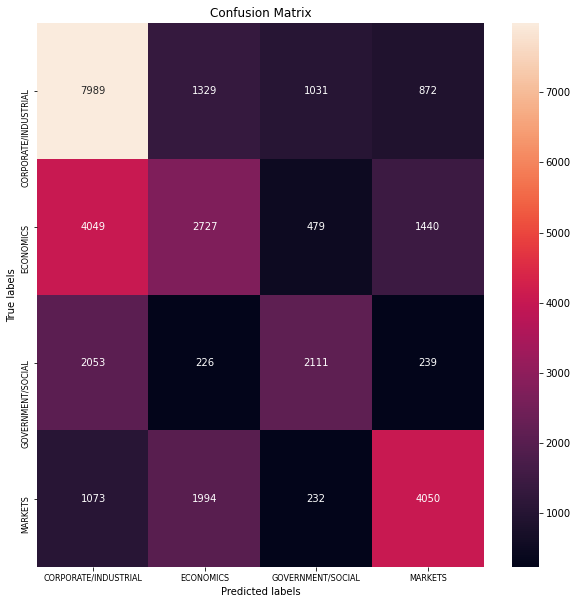

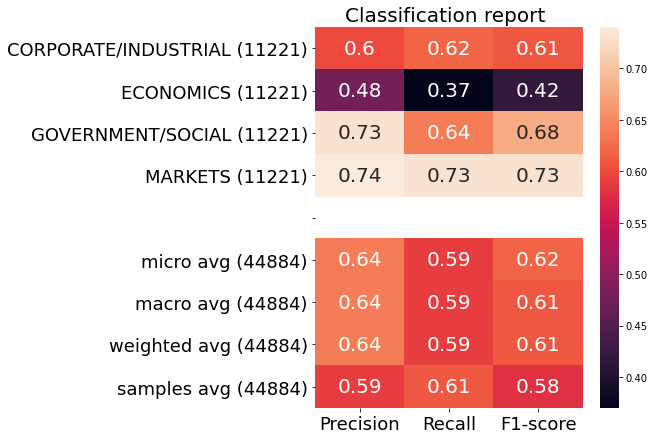

ROC AUC SCORE: 0.7066212448824529


In [50]:
path_adaboost="/home/mattia_gatto/text-mining-use-cases/src/use_cases/use_case_topic_classification/Models/ADABOOST/"
# path_adaboost='C:/Users/matti/Desktop/progetto/text-mining-use-cases-mattia_gatto/src/use_cases/use_case_topic_classification/Models/ADABOOST/'
n_estimators=50
model=AdaBoostClassifier( n_estimators=n_estimators,algorithm="SAMME")
if labels_59!=True:
    f = path_adaboost+"ADABOOST_moc_clf_Text_new_"+ str(n_estimators)
else:
    f = path_adaboost+"ADABOOST_moc_clf_Text_new_59_"+ str(n_estimators)
    
multi_output_classifier,y_pred,ris_ADABOOST_auc=train_classifier(f,model,class_names_list)
#4h:30min circa

### 5 fold_validation
---

In [51]:
if labels_59!=True:
    start_time=time_calculate()
    f_5 = path_adaboost+"ADABOOST_moc_clf_Text_new_"+ str(n_estimators)+'_val_5fold'
    scores_ada = val_5fold(multi_output_classifier, X_Train, y_train,f_5)
    end_time=time_calculate(bool_t=False,start_time=start_time)
    print(np.mean(scores_ada))
else:
    print()
#     f_5 = path_adaboost+"ADABOOST_moc_clf_Text_new_59_"+ str(n_estimators)+'_val_5fold'

START:  2022-03-27 14:27
MODELLO PRECEDENTEMENTE VALIDATO CARICATO
END:  2022-03-27 14:27
tempo impiegato 0d:00h:00m:00s
0.8011608070891914


### Prediction
---

START:  2022-03-27 12:51


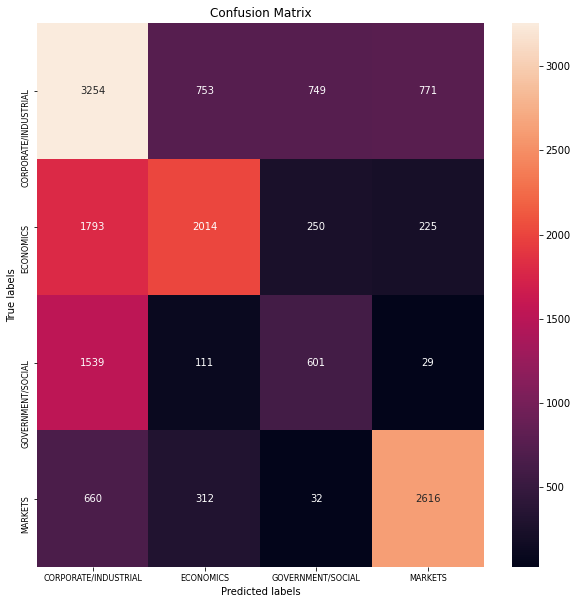

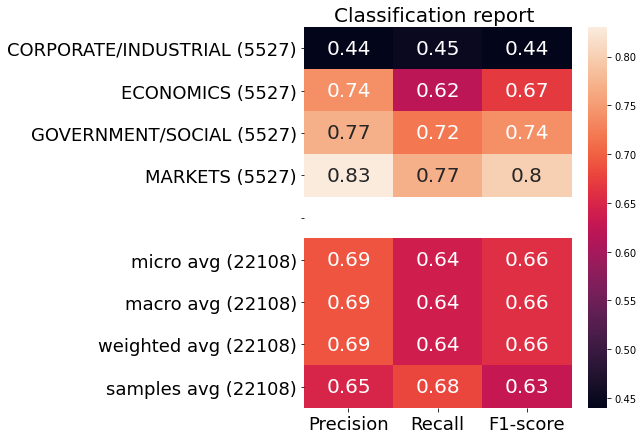

ROC AUC SCORE: 0.7404709410850262
END:  2022-03-27 12:51
tempo impiegato 0d:00h:00m:08s


In [22]:
start_time=time_calculate()
prediction(multi_output_classifier,X_Test,y_test)
end_time=time_calculate(bool_t=False,start_time=start_time)

---
# SVM
---

START:  2022-03-27 12:51
MODELLO GIA' ADDESTRATO
END:  2022-03-27 12:51
tempo impiegato 0d:00h:00m:26s


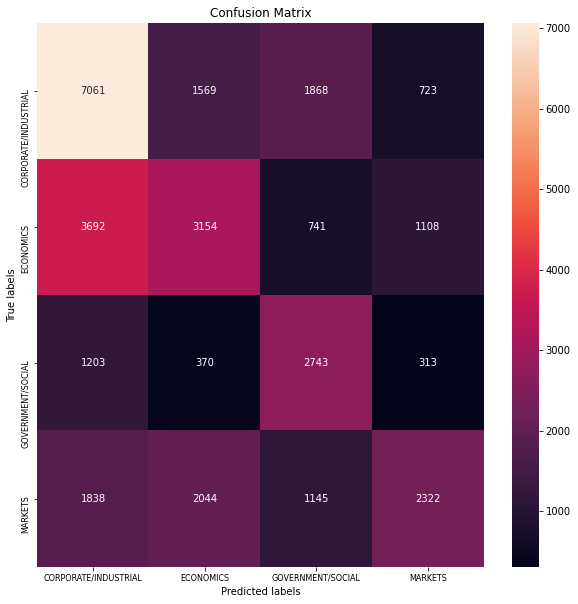

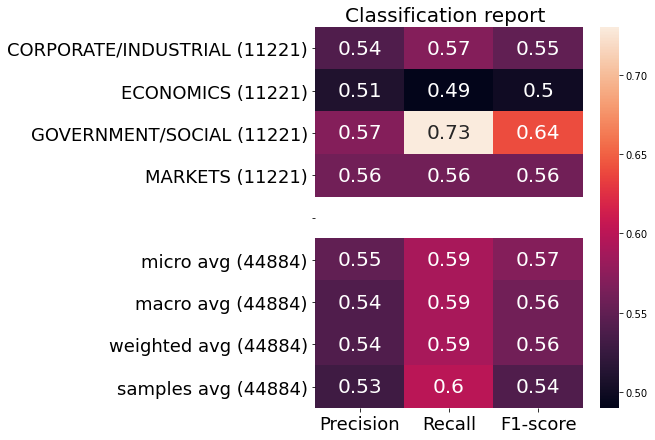

ROC AUC SCORE: 0.6621507527600357


In [23]:
# SVM con kernel lineare 
path_svm="/home/mattia_gatto/text-mining-use-cases/src/use_cases/use_case_topic_classification/Models/SVM/"
# path_SVM='C:/Users/matti/Desktop/progetto/text-mining-use-cases-mattia_gatto/src/use_cases/use_case_topic_classification/Models/SVM/'
model=SVC(kernel='linear', C=1,verbose=1)
if labels_59!=True:
    f = path_svm+"SVM_moc_clf_Text"+"_linear"
    multi_output_classifier,y_pred,ris_SVM_auc=train_classifier(f,model,class_names_list)
else:
    print()
#     f = path_svm+"SVM_moc_clf_Text_59"+"_linear"
#     multi_output_classifier,y_pred,ris_SVM_auc=train_classifier(f,model,class_names_list)

### 5 fold_validation
---

In [24]:
# start_time=time_calculate()
# if labels_59!=True:
#     f_5 = path_svm+"SVM_moc_clf_Text_"+'linear'+'_val_5fold'
# else:
#     f_5 = path_svm+"SVM_moc_clf_Text_59_"+'linear'+'_val_5fold'
    
# scores_svm = val_5fold(multi_output_classifier, X_Train, y_train,f_5)
# end_time=time_calculate(bool_t=False,start_time=start_time)
# print(np.mean(scores_svm))

### Prediction
---

START:  2022-03-27 13:32


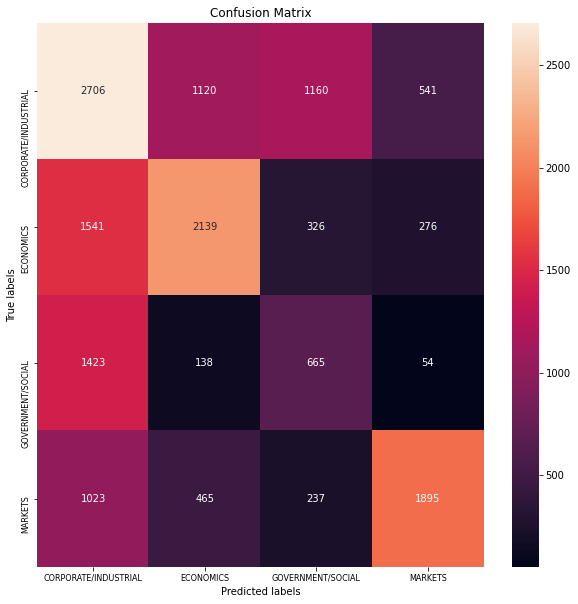

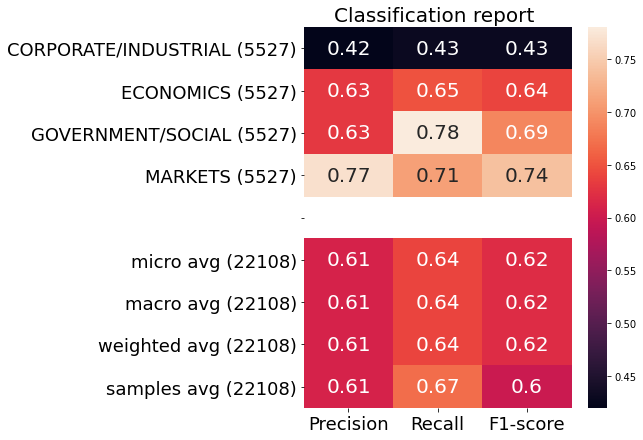

ROC AUC SCORE: 0.7085525523405982
END:  2022-03-27 13:53
tempo impiegato 0d:00h:20m:17s


In [25]:
if labels_59!=True:
    start_time=time_calculate()
    prediction(multi_output_classifier,X_Test,y_test)
    end_time=time_calculate(bool_t=False,start_time=start_time)

---
# Albero Decisionale
---

START:  2022-03-27 13:53
MODELLO GIA' ADDESTRATO
END:  2022-03-27 13:53
tempo impiegato 0d:00h:00m:00s


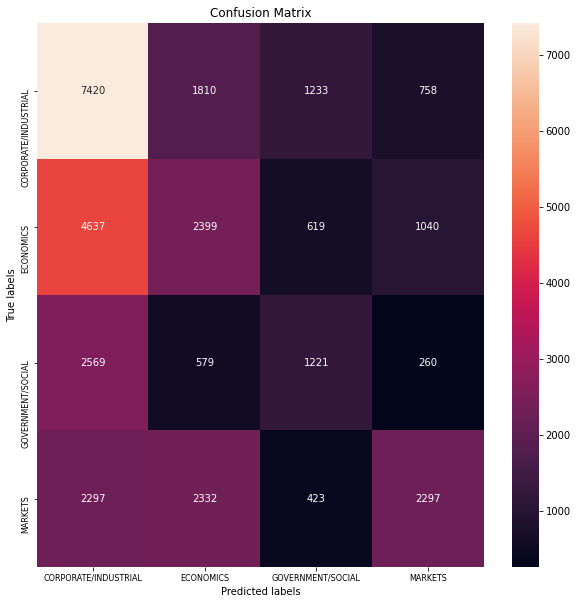

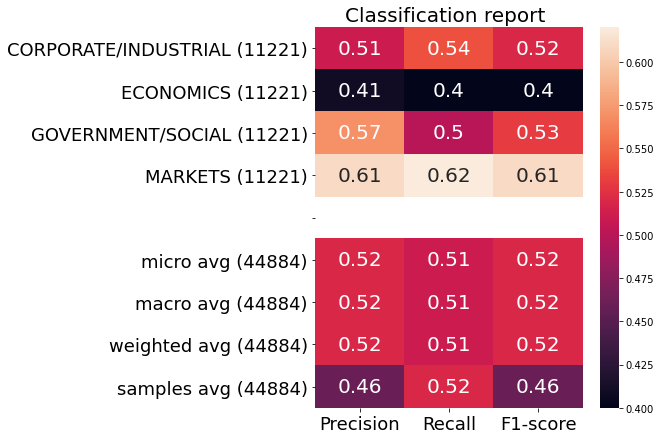

ROC AUC SCORE: 0.6294905277316698


In [26]:
path_decision_tree="/home/mattia_gatto/text-mining-use-cases/src/use_cases/use_case_topic_classification/Models/DECISIONTREE/"
# path_adaboost='C:/Users/matti/Desktop/progetto/text-mining-use-cases-mattia_gatto/src/use_cases/use_case_topic_classification/Models/DECISIONTREE/'
model=DecisionTreeClassifier()
if labels_59!=True:
    f = path_decision_tree+"DECISIONTREE_moc_clf_Text"
else:
    f = path_decision_tree+"DECISIONTREE_moc_clf_Text_59"
    
multi_output_classifier,y_pred,ris_DecisionTreeClassifier_auc=train_classifier(f,model,class_names_list)
# 21h 56min

### 5 fold_validation

In [27]:
if labels_59!=True:
    start_time=time_calculate()
    f_5 = path_decision_tree+"DECISIONTREE_moc_clf_Text_val_5fold"
    scores_DecisionTreeClassifier = val_5fold(multi_output_classifier, X_Train, y_train,f_5)
    end_time=time_calculate(bool_t=False,start_time=start_time)
    print(np.mean(scores_DecisionTreeClassifier))
else:
    print()
#     start_time=time_calculate()
#     f_5 = path_decision_tree+"DECISIONTREE_moc_clf_Text_val_59_5fold"
#     scores_DecisionTreeClassifier = val_5fold(multi_output_classifier, X_Train, y_train,f_5)
#     end_time=time_calculate(bool_t=False,start_time=start_time)
#     print(np.mean(scores_DecisionTreeClassifier))


START:  2022-03-27 13:53
MODELLO PRECEDENTEMENTE VALIDATO CARICATO
END:  2022-03-27 13:53
tempo impiegato 0d:00h:00m:00s
0.7871090862425076


### Prediction
---

START:  2022-03-27 13:53


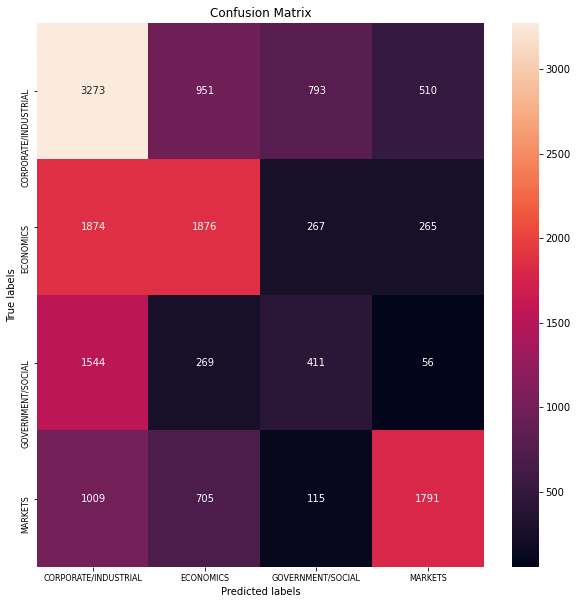

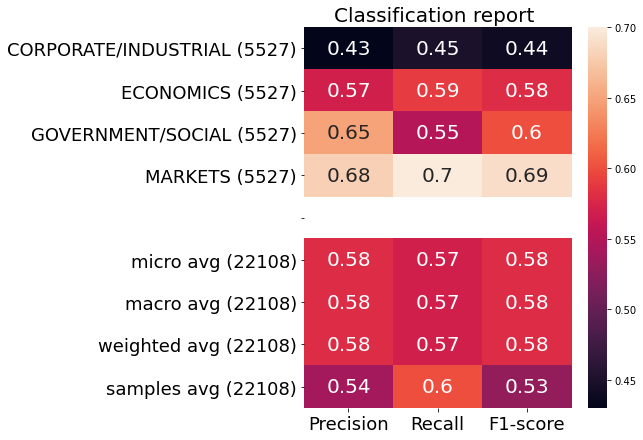

ROC AUC SCORE: 0.674213398826361
END:  2022-03-27 13:53
tempo impiegato 0d:00h:00m:04s


In [28]:
start_time=time_calculate()
prediction(multi_output_classifier,X_Test,y_test)
end_time=time_calculate(bool_t=False,start_time=start_time)

---
# Clear variables
---

In [29]:
# clear variables
del multi_output_classifier
del y_pred
del model
del X_Train
del X_tfidf_pca
del X_Validation
del X_tfidf_validation_pca
del X_Test
del X_tfidf_test_pca